In [50]:
# Import packages
import csv # Read in case parameters and write out solutions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [51]:
class case_param(): 
    def __init__(self,param): 
        self.name = param['case_name'] # now the name is given inside the case, not as the case's actual name 
        self.dim = 1 # dimensions 
        self.x0 = 0.0 # inlet position 
        self.xL = self.x0 + float(param['length']) # outlet 
        self.dx = float(param['dx'])
        fluid_name = param['fluid'] 
        mu = float(param['mu']) 
        u0 = 0.0 
        p0 = float(param['p0']) # inlet pressure 
        pL = float(param['pL']) # outlet 
        self.fl = {'Name': fluid_name, 'mu': mu, 'u0': u0, 'p0': p0, 'pL': pL} 
        pm_name = param['porous_medium']  
        K = float(param['K']) 
        eps = float(param['eps']) 
        self.pm = {'Name': pm_name, 'K':K, 'eps':eps} 
        self.fl['u0'] = -K/mu*(pL-p0)/(self.xL-self.x0)

In [52]:
class mesh():
    def __init__(self,case): # Take in the case info for certain params
        dim = 1 # case.dim
        if (dim == 1):
            self.Nx = int((case.xL - case.x0)/case.dx + 2.0)
        
            # Face locations
            self.xc = np.ones(self.Nx)*case.x0# Initialize mesh
            self.xc[self.Nx-1] = case.xL # Outward boundary
            for i in range(2,self.Nx-1): 
                self.xc[i] = (i-1)*case.dx # Cell Face Locations

            # Node locations
            self.x = np.copy(self.xc) # Initialize mesh
            for i in range(0,self.Nx-1):
                self.x[i] = (self.xc[i+1] + self.xc[i])/2 # Cell Node Locations: halfway between faces
            self.x[self.Nx-1] = np.copy(self.xc[self.Nx-1]) # Outward boundary
    def output(self,fname): # output mesh
        with open(fname,'w', newline='') as csvfile:
            mesh_write = csv.writer(csvfile,dialect = 'excel', delimiter = '\t') # writer object
            mesh_write.writerow(['i', 'x', 'xc']) # header row
            for i in range(0,self.Nx):
                mesh_write.writerow([i+1,self.x[i],self.xc[i]]) # actual data rows

In [53]:
class fluid():
    def __init__(self,mesh,fluid_prop):
        self.name = fluid_prop['Name']
        # Initialize variables
        self.p = np.ones(mesh.Nx)*fluid_prop['p0'] # Pressure
        self.p[mesh.Nx-1] = fluid_prop['pL'] # Pressure boundary at x = L
        self.u = np.ones(mesh.Nx)*fluid_prop['u0'] # Velocity: Staggered mesh so velocity at faces
        self.mu = np.ones(mesh.Nx)*fluid_prop['mu'] # Viscosity
    def p_lin(self,mesh): # linear pressure-x relation
        N = mesh.Nx
        L = mesh.x[N-1]
        L0 = mesh.x[0]
        for i in range(1,N):
            self.p[i] = (self.p[N-1]-self.p[0])/(L-L0)*mesh.x[i]+self.p[0]
    def mu_lin(self,mesh): # linear viscosity-x relation
        N = mesh.Nx
        L = mesh.x[N-1]
        L0 = mesh.x[0]
        for i in range(1,N):
            self.mu[i] = (0.005-0.001)/(L-L0)*mesh.x[i]+0.001
    def darcyv(self,msh,pm):
        # inlet
        self.u[0] = -np.mean([pm.K[0]/self.mu[0],pm.K[1]/self.mu[1]]) \
        *(self.p[1]-self.p[0])/(msh.x[1]-msh.x[0]) 
        self.u[1] = self.u[0] # same location
        for i in range(2,msh.Nx-1): # interior faces
            Ai = pm.K[i-1]/self.mu[i-1]/(msh.xc[i]-msh.x[i-1])
            Ai1 = pm.K[i]/self.mu[i]/(msh.x[i]-msh.xc[i])
            self.u[i] = -Ai*Ai1/(Ai+Ai1)*(self.p[i]-self.p[i-1])
        # outlet
        self.u[msh.Nx-1] = -np.mean([pm.K[msh.Nx-2]/self.mu[msh.Nx-2], \
                                     pm.K[msh.Nx-1]/self.mu[msh.Nx-1]])* \
        (self.p[msh.Nx-1]-self.p[msh.Nx-2])/(msh.x[msh.Nx-1]-msh.x[msh.Nx-2]) 
        
    def gauss_seidel(self,msh,pm): # need the mesh info and porous medium permeability

        # Solver Parameters
        tol = 1E-7 # tolerance to determining stopping point of scheme
        res = np.array([1.0],dtype=float) # residual (initially greater than the tolerance
        max_iter = 100 # max iterations (so it doesn't go forever)
        k = 0 # iteration counter

        # self.p[2:N-1] = zeros(N-2,1) # initial guess for cell centers
        p_samp = np.zeros([1,4],dtype=float)
        p_samp[0][:] = np.copy([self.p[1],self.p[3],self.p[msh.Nx-4],self.p[msh.Nx-2]])
        
        ## Iteration Loop
        while ((res[k]>tol)and(k<max_iter)):
            p_prev = np.copy(self.p)# previous iteration (copy to avoid using same mem loc)
            i = 1 # first cell center
            fw = -np.mean([pm.K[i-1]/self.mu[i-1],pm.K[i]/self.mu[i]])/(msh.x[i]-msh.xc[i]) # f_i-1/2 -> f_i
            fe = -pm.K[i]/self.mu[i]/(msh.xc[i+1]-msh.x[i]) # f_i -> f_i+1/2
            fee = -pm.K[i+1]/self.mu[i+1]/(msh.x[i+1]-msh.xc[i+1]) #f_i+1/2 -> f_i+1
            Aw = fw
            Ae = fe*fee/(fe+fee)
            self.p[i] = (Aw*self.p[i-1] + Ae*self.p[i+1])/(Aw + Ae)
            for i in range(2,msh.Nx-2):
                fww = -pm.K[i-1]/self.mu[i-1]/(msh.xc[i]-msh.x[i-1]) # f_i-1->i-1/2
                fw = -pm.K[i]/self.mu[i]/(msh.x[i]-msh.xc[i]) # f_i-1/2 -> f_i
                fe = -pm.K[i]/self.mu[i]/(msh.xc[i+1]-msh.x[i]) # f_i -> f_i+1/2
                fee = -pm.K[i+1]/self.mu[i+1]/(msh.x[i+1]-msh.xc[i+1]) # f_i+1/2 -> f_i+1
                Aw = fw*fww/(fw+fww) # "west" factor (i-1 -> i)
                Ae = fe*fee/(fe+fee) # "east" factor (i -> i+1)
                self.p[i] = (Aw*self.p[i-1] + Ae*self.p[i+1])/(Aw + Ae)
            i = msh.Nx-2 # last cell center
            fww = -pm.K[i-1]/self.mu[i-1]/(msh.xc[i]-msh.x[i-1]) # f_i-1->i-1/2
            fw = -pm.K[i]/self.mu[i]/(msh.x[i]-msh.xc[i]) # f_i-1/2 -> f_i
            fe = -np.mean([pm.K[i]/self.mu[i],pm.K[i+1]/self.mu[i+1]]) \
                          /(msh.xc[i+1]-msh.x[i]) # f_i -> f_i+1/2
            Aw = fw*fww/(fw+fww) 
            Ae = fe 
            self.p[i] = (Aw*self.p[i-1] + Ae*self.p[i+1])/(Aw + Ae)
            p_samp = np.append(p_samp,[[self.p[1],self.p[3],self.p[msh.Nx-4],self.p[msh.Nx-2]]],axis=0)
            res = np.append(res,[sum(abs(self.p-p_prev))]) # L2 norm of p_diff
            k += 1 # increase iteration count
            # print(k,res[k-1])
            
        # Iterations are complete. Now for output
        print('Gauss-Seidel Complete. Iteration, Residual:',k,res[k])
        
        # I suggest using the pandas library for output to file. Compare the code below to the output
        # function coded from scratch in the mesh class
        res_vec = res[:,np.newaxis]
        df = pd.DataFrame(np.append(res_vec,p_samp,axis=1),columns=['res','x1','x3','x_N-4','x_N-2'])
        df.to_csv('GS_Out.csv',sep='\t')       
        return [k,res[k]]


In [54]:
class por_med():
    def __init__(self,mesh,pm_prop):
        self.name = pm_prop
        # Initialize Variables
        self.K = np.ones(mesh.Nx)*pm_prop['K'] # Permeability
        self.eps = np.ones(mesh.Nx)*pm_prop['eps'] # Porosity

In [55]:
def plot_out(data): # plotting function, takes in data object of specific form and prints plots
    N_param = data.Np
    N = data.Nx
    fig, ax = plt.subplots(N_param,1,figsize=(4,5))    
    for i in range(0,N_param):
        ax[i].plot(data.x, data.var[0:,i], color = 'black',linewidth=0.5)
        ax[i].set_xlabel(data.varnamex,fontsize=12) 
        ax[i].set_ylabel(data.varname[i],fontsize=12)
    fig.tight_layout()
    plt.show()

def output(fname,fheader,Nvar,N,data): # output data files
    # fname: str variable - name.fmt (replace fmt with desired file format)
    # fheader: str array with each string being a variable name
    # Nvar: number of variables
    # N: length of data vectors (number of rows)
    # data: array with shape
    with open(fname,'w', newline='') as csvfile:
        data_write = csv.writer(csvfile,dialect = 'excel', delimiter = '\t') # writer object
        data_write.writerow(fheader) # header row
        for i in range(0,self.Nx):
            mesh_write.writerow([i+1,self.x[i],self.xc[i]]) # actual data rows

In [56]:
with open('casefile.csv',newline='') as casefile: 
    casereader = csv.DictReader(casefile) 
    i = 0 
    caselist = {} 
    for row in casereader:    
        caselist[i] = row 
        i += 1         

base = case_param(caselist[0])
print(base.x0)
print(base.dx)

0.0
0.02


In [57]:
## Initialize and check mesh object creation ##
base_mesh = mesh(base) # create base mesh from case parameters
print('Node Locations w/ inlet:', base_mesh.x[0:5]) # check inlet location and spacing
print('Nx:', base_mesh.Nx) # check number of elements
print('Outlet Location:', base_mesh.x[base_mesh.Nx-1])
print('Face Locations:', base_mesh.xc[0:5]) #

Node Locations w/ inlet: [0.   0.01 0.03 0.05 0.07]
Nx: 52
Outlet Location: 1.0
Face Locations: [0.   0.   0.02 0.04 0.06]


In [58]:
## Create fluid and porous medium objects for this specific case ##
fl1 = fluid(base_mesh,base.fl) # fluid object, determined by mesh and case's fluid properties
pm1 = por_med(base_mesh,base.pm) # porous medium object, determined by mesh and case's porous medium properties

In [59]:
# Linear P
print('Original P:',fl1.p[0:4],fl1.p[base_mesh.Nx-5:base_mesh.Nx-1])
fl1.p_lin(base_mesh)
print('Linear P:',fl1.p[0:4],fl1.p[base_mesh.Nx-5:base_mesh.Nx-1])

Original P: [0. 0. 0. 0.] [0. 0. 0. 0.]
Linear P: [ 0. -1. -3. -5.] [-93. -95. -97. -99.]


In [60]:
# Darcy Velocity
print('Original u:',fl1.u[0:4]) # velocity from initialization
fl1.u = np.zeros(base_mesh.Nx) # zero out velocity 
fl1.darcyv(base_mesh,pm1) # use darcyv method
print('Darcy u:',fl1.u[0:4]) # print to confirm that darcyv did what it was supposed to (got same solution as initialization)

Original u: [1.e-04 1.e-04 1.e-04 1.e-04]
Darcy u: [1.e-04 1.e-04 1.e-04 1.e-04]


In [61]:
# Data/solution object to be plotted #
data_sol = type('sol', (object,), {})() # empty object (metaprogramming)

In [62]:
# Data at nodes: x p, K, mu
data_sol.Np = 3 # p, K, mu
data_sol.Nx = base_mesh.Nx
data_sol.varnamex = 'x (m)'
data_sol.varname = ['p (Pa)', 'K ($m^2$)', '\u03BC (Pa*s)']
data_sol.x = base_mesh.x
data_sol.var = np.zeros((data_sol.Nx,data_sol.Np))
data_sol.var = np.concatenate((fl1.p.reshape(data_sol.Nx,1)
                               ,pm1.K.reshape(data_sol.Nx,1)
                               ,fl1.mu.reshape(data_sol.Nx,1))
                              ,axis=1)

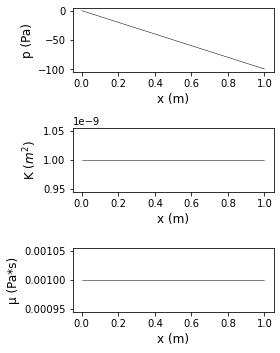

In [63]:
plot_out(data_sol) # call the plotting output

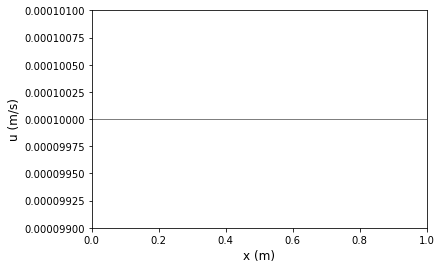

In [64]:
# Face only has one variable right now, so can directly plot
fig2, ax2 = plt.subplots()
ax2.plot(base_mesh.xc,fl1.u,color='black',linewidth=0.5)
ax2.set_xlabel('x (m)',fontsize=12) 
ax2.set_ylabel('u (m/s)',fontsize=12)
plt.xlim(min(base_mesh.xc),max(base_mesh.xc))
plt.ylim(min(fl1.u)-1E-6,max(fl1.u)+1E-6)
plt.show()

In [65]:
## Pressure calculation using Gauss-Seidel
fl_gs = fluid(base_mesh,base.fl)
print('Original P:',fl_gs.p[0:4],
      fl_gs.p[base_mesh.Nx-5:base_mesh.Nx-1])
[itera, res] = fl_gs.gauss_seidel(base_mesh,pm1)
print('Gauss-Seidel P:',fl_gs.p[0:4],
      fl_gs.p[base_mesh.Nx-5:base_mesh.Nx-1])
fl_gs2 = copy.deepcopy(fl_gs) # another 100 iterations
[itera, res] = fl_gs2.gauss_seidel(base_mesh,pm1)
fl_gs3 = copy.deepcopy(fl_gs2) # another 100 iterations
[itera, res] = fl_gs3.gauss_seidel(base_mesh,pm1)

Original P: [0. 0. 0. 0.] [0. 0. 0. 0.]
Gauss-Seidel Complete. Iteration, Residual: 100 5.65338582708514
Gauss-Seidel P: [ 0.         -0.00138227 -0.00462155 -0.00872932] [-80.27557742 -85.87430752 -91.51599336 -97.17199779]
Gauss-Seidel Complete. Iteration, Residual: 100 3.7583134653374475
Gauss-Seidel Complete. Iteration, Residual: 100 2.5634702135882383


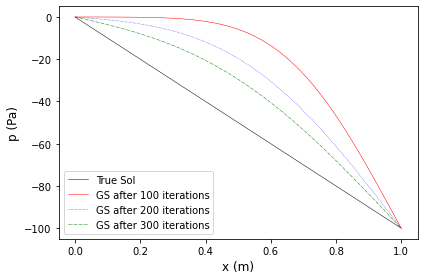

In [66]:
# Plotting with Comparison
comp = type('sol', (object,), {})() # 'comp' for comparison
comp.Np = 4 # true p, dp_100iter, dp_200_iter, dp_300iter
comp.Nx = base_mesh.Nx
comp.varnamex = 'x (m)'
comp.varname = ['True Sol','GS after 100 iterations',
                    'GS after 200 iterations', 'GS after 300 iterations']
comp.x = base_mesh.x
comp.var = np.zeros((comp.Nx,comp.Np))
comp.var = np.concatenate((fl1.p.reshape(comp.Nx,1)
                               ,fl_gs.p.reshape(comp.Nx,1)
                               ,fl_gs2.p.reshape(comp.Nx,1)
                               ,fl_gs3.p.reshape(comp.Nx,1))
                              ,axis=1)
fig1, ax1 = plt.subplots()
ax1.plot(comp.x,comp.var[:,0],'k',linewidth=0.5,label=comp.varname[0])
ax1.plot(comp.x,comp.var[:,1],'r-',linewidth=0.5,label=comp.varname[1])
ax1.plot(comp.x,comp.var[:,2],'b:',linewidth=0.5,label=comp.varname[2])
ax1.plot(comp.x,comp.var[:,3],'g-.',linewidth=0.5,label=comp.varname[3])
ax1.set_xlabel(comp.varnamex,fontsize=12) 
ax1.set_ylabel('p (Pa)',fontsize=12)
ax1.legend()
fig1.tight_layout()
plt.show()

In [67]:
## Until Convergence
fl_gs_conv = copy.deepcopy(fl_gs3)
for i in range(0,50):
    [itera, res] = fl_gs_conv.gauss_seidel(base_mesh,pm1)

Gauss-Seidel Complete. Iteration, Residual: 100 1.7346754689575967
Gauss-Seidel Complete. Iteration, Residual: 100 1.170213355095012
Gauss-Seidel Complete. Iteration, Residual: 100 0.7886626690301054
Gauss-Seidel Complete. Iteration, Residual: 100 0.5313600983521762
Gauss-Seidel Complete. Iteration, Residual: 100 0.3579706262053608
Gauss-Seidel Complete. Iteration, Residual: 100 0.24115368085189048
Gauss-Seidel Complete. Iteration, Residual: 100 0.16245637437907423
Gauss-Seidel Complete. Iteration, Residual: 100 0.10944061071299471
Gauss-Seidel Complete. Iteration, Residual: 100 0.07372587247410722
Gauss-Seidel Complete. Iteration, Residual: 100 0.049666234002162746
Gauss-Seidel Complete. Iteration, Residual: 100 0.03345819504829006
Gauss-Seidel Complete. Iteration, Residual: 100 0.02253947402453349
Gauss-Seidel Complete. Iteration, Residual: 100 0.015183959719024531
Gauss-Seidel Complete. Iteration, Residual: 100 0.010228838171966625
Gauss-Seidel Complete. Iteration, Residual: 100 0.0

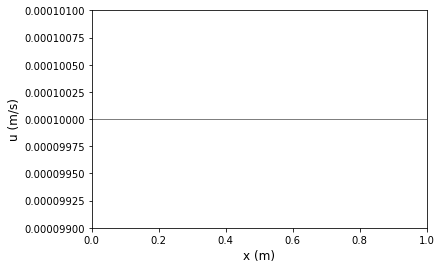

In [68]:
# Velocity
fl_gs_conv.darcyv(base_mesh,pm1)
fig3, ax3 = plt.subplots()
ax3.plot(base_mesh.xc,fl_gs_conv.u,color='black',linewidth=0.5)
ax3.set_xlabel('x (m)',fontsize=12) 
ax3.set_ylabel('u (m/s)',fontsize=12)
plt.xlim(min(base_mesh.xc),max(base_mesh.xc))
plt.ylim(min(fl1.u)-1E-6,max(fl1.u)+1E-6)
plt.show()

In [69]:
fl_gs_mulin = fluid(base_mesh,base.fl)
print('Original P:',fl_gs_mulin.p[0:4],
      fl_gs_mulin.p[base_mesh.Nx-5:base_mesh.Nx-1])
fl_gs_mulin.p_lin(base_mesh)
print('Linear P:',fl_gs_mulin.p[0:4],
      fl_gs_mulin.p[base_mesh.Nx-5:base_mesh.Nx-1])
fl_gs_mulin.mu_lin(base_mesh)
for k in range(0,51): [itera, res] = fl_gs_mulin.gauss_seidel(base_mesh,pm1)
print('Final P:',fl_gs_mulin.p[0:4],
      fl_gs_mulin.mu[base_mesh.Nx-5:base_mesh.Nx-1])

Original P: [0. 0. 0. 0.] [0. 0. 0. 0.]
Linear P: [ 0. -1. -3. -5.] [-93. -95. -97. -99.]
Gauss-Seidel Complete. Iteration, Residual: 100 1.5884833745040403
Gauss-Seidel Complete. Iteration, Residual: 100 1.002353041483502
Gauss-Seidel Complete. Iteration, Residual: 100 0.6338472261195084
Gauss-Seidel Complete. Iteration, Residual: 100 0.40049374184656666
Gauss-Seidel Complete. Iteration, Residual: 100 0.2529740027291516
Gauss-Seidel Complete. Iteration, Residual: 100 0.1597775646522766
Gauss-Seidel Complete. Iteration, Residual: 100 0.1009121836541308
Gauss-Seidel Complete. Iteration, Residual: 100 0.06373350241738468
Gauss-Seidel Complete. Iteration, Residual: 100 0.04025231667888601
Gauss-Seidel Complete. Iteration, Residual: 100 0.025422230427992742
Gauss-Seidel Complete. Iteration, Residual: 100 0.01605596169998358
Gauss-Seidel Complete. Iteration, Residual: 100 0.010140490604018504
Gauss-Seidel Complete. Iteration, Residual: 100 0.006404446494256144
Gauss-Seidel Complete. Iterati

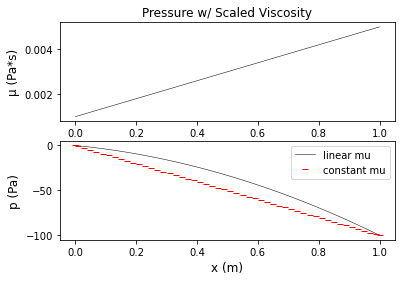

In [70]:
fl_gs_mulin.darcyv(base_mesh,pm1) # Check velocity
# Plot Comparison
fig4, ax4 = plt.subplots(2,1)
ax4[0].plot(comp.x,fl_gs_mulin.mu,'k',linewidth=0.5)
ax4[0].set_xlabel(comp.varnamex,fontsize=12) 
ax4[0].set_ylabel('\u03BC (Pa*s)',fontsize=12)
ax4[0].set(title='Pressure w/ Scaled Viscosity')
ax4[1].plot(comp.x,fl_gs_mulin.p,'k',linewidth=0.5,label='linear mu')
ax4[1].plot(comp.x,fl_gs_conv.p,'r_',linewidth=0.5,label ='constant mu' )
ax4[1].set_xlabel(comp.varnamex,fontsize=12) 
ax4[1].set_ylabel('p (Pa)',fontsize=12)
ax4[1].legend()

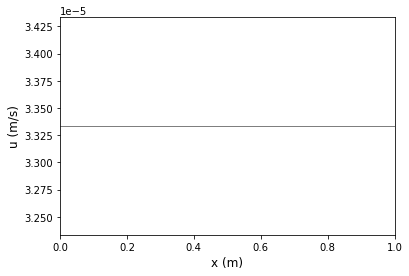

In [73]:
# Velocity for linear viscosity
fig5, ax5 = plt.subplots()
ax5.plot(base_mesh.xc,fl_gs_mulin.u,color='black',linewidth=0.5)
ax5.set_xlabel('x (m)',fontsize=12) 
ax5.set_ylabel('u (m/s)',fontsize=12)
plt.xlim(min(base_mesh.xc),max(base_mesh.xc))
plt.ylim(min(fl_gs_mulin.u)-1E-6,max(fl_gs_mulin.u)+1E-6)
plt.show()